

## Whats Covered
- **Mechanistic Interpretability:** Why it’s important to understand how AI models work inside.
- **Transformer Architecture:** How attention helps models focus on important words.
- **Induction Heads:** How models spot and repeat patterns, like finishing a sentence.
- **In-Context Learning:** How models learn from examples without retraining.
- **Phase Change:** The moment when models suddenly “get it” during training.
- **Evidence and Analysis:** Proof that induction heads matter.
- **Advanced Topics:** Generalization and the role of model design.
- **Why This Matters:** How understanding AI helps make it safer and better.

## What You Need
- Python and a few libraries (we’ll install them).
- No prior AI knowledge—we’ll explain everything step by step!

Let’s dive in!

In [1]:
# Install libraries if needed (uncomment and run)
!pip install torch numpy matplotlib transformers transformer_lens

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformer_lens import HookedTransformer

# Use GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {device}')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 56.5 MB/s eta 0:00:00

## 1. Mechanistic Interpretability: Understanding the AI Black Box

### What Is Mechanistic Interpretability?
Mechanistic interpretability is about figuring out how AI models, like transformers, make decisions. Instead of treating them as mysterious “black boxes” that spit out answers, we look inside to see the step-by-step processes—or “circuits”—that lead to those answers.

### Why Does It Matter?
- **Safety:** If we know how an AI decides, we can stop it from making dangerous choices (e.g., misinterpreting instructions).
- **Debugging:** When the AI messes up, we can pinpoint why and fix it.
- **Scientific Discovery:** It reveals how machines “think,” which could teach us about human intelligence too.

**Relatable Example:** Imagine you have a robot chef. It makes a great cake, but one day it adds salt instead of sugar. By understanding its “recipe” (its circuits), you can fix the mistake and ensure it uses sugar next time.

**Deeper Insight:** Transformers are complex, with millions of parameters. Mechanistic interpretability breaks them down into understandable parts, like mapping the wires in a computer.

## 2. Core Transformer Architecture: The Building Blocks

### What’s a Transformer?
A transformer is a type of AI model that’s great at understanding and generating text. It’s built from layers of “attention” and other components that work together to process words.

### Subtopic 2.1: Attention Mechanism
- **What It Does:** Attention lets the model focus on the most important words in a sentence, even if they’re far apart.
- **How It Works:** Each word gets a score based on how relevant it is to every other word. High scores mean more focus.

**Relatable Example:** At a noisy party, you tune out the chatter to hear your friend say “cake fell.” Attention is like that—ignoring the noise to catch the key parts of a story.

### Subtopic 2.2: Layers
- Transformers have multiple layers, each refining the understanding of the text.
- Each layer has attention heads (like mini-workers) that specialize in different tasks.

**Simple Analogy:** Think of layers as floors in a building. The ground floor sorts the basics (words), and each floor above adds more detail (meaning, context).

### Subtopic 2.3: Circuits
- Circuits are the patterns of computation inside the model—like tiny programs that handle specific jobs.
- Example: One circuit might link subjects to verbs (e.g., “dog” to “barked”).

**Let’s See It:** We’ll load a small transformer and visualize its attention.

Loaded pretrained model gpt2 into HookedTransformer


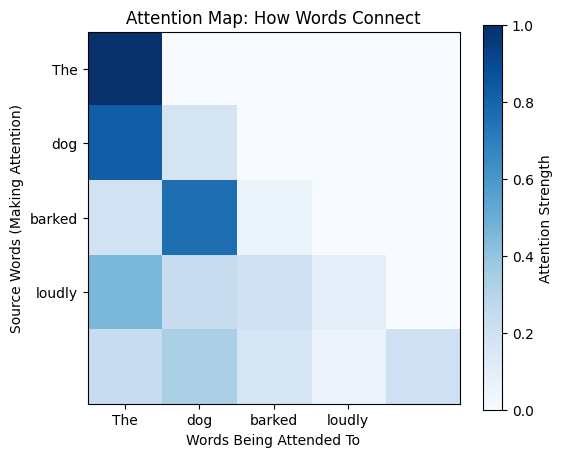

In [3]:
# Import necessary libraries
from transformers import AutoTokenizer
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt

# Load GPT-2 tokenizer (converts text<->numbers)
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Load GPT-2 model using TransformerLens wrapper
# HookedTransformer gives us access to internal activations
model = HookedTransformer.from_pretrained('gpt2', device=device)

# Define input text and convert to tokens
text = "The dog barked loudly"
# Tokenize text to numerical IDs, add batch dimension, send to GPU
tokens = tokenizer.encode(text, return_tensors='pt').to(device)

# Run model with caching - returns logits and activation cache
# cache will store all intermediate values at each layer
logits, cache = model.run_with_cache(tokens)

# Convert token IDs back to words for labeling
# [0] selects first (and only) batch, split into list of words
words = tokenizer.decode(tokens[0]).split()

# Get attention patterns from first layer (layer 0)

# [0,0] indexes into (batch=0, head=0) for first layer
attention = cache['blocks.0.attn.hook_pattern'][0, 0].cpu().numpy()

# Create figure for visualization
plt.figure(figsize=(6, 5))

# Plot attention matrix using blue color scheme
plt.imshow(attention, cmap='Blues')

# Set axis labels using words
plt.xticks(range(len(words)), words)
plt.yticks(range(len(words)), words)

# Add title and axis descriptions
plt.title('Attention Map: How Words Connect')
plt.xlabel('Words Being Attended To')
plt.ylabel('Source Words (Making Attention)')

# Add color intensity legend
plt.colorbar(label='Attention Strength')

# Save and display
plt.savefig('attention_map.png')
plt.show()

**What’s This Show?**
- Bright spots show strong attention (e.g., “barked” focusing on “dog”).
- It’s like a heatmap of how the model listens to the sentence.

**Deeper Insight:** Attention lets transformers handle long sentences by connecting distant words, unlike older models that struggled with distance.

## 3. Induction Heads: Pattern Detectives

### Subtopic 3.1: Definition
- Induction heads are specialized attention heads that spot repeating patterns in text and predict what comes next.

**Relatable Example:** If you say “Twinkle, twinkle, little…,” your friend says “star.” Induction heads do that for AI.

### Subtopic 3.2: Mechanism
- **Two-Step Teamwork:**
  1. **Previous Token Head:** Remembers what came before (e.g., “red”).
  2. **Induction Head:** Looks back for earlier matches and copies what followed (e.g., “blue” after “red”).

**Simple Example:** In “A B A,” the model predicts “B” after the second “A” by recalling the earlier “A B.”

### Subtopic 3.3: Examples
Let’s test it with a small model.

Loaded pretrained model attn-only-2l into HookedTransformer


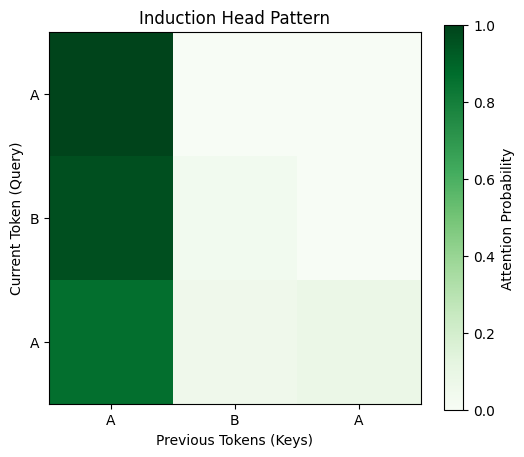

In [7]:
# Load a 2-layer attention-only model using TransformerLens
# (This model architecture only uses attention layers)
model = HookedTransformer.from_pretrained('attn-only-2l', device=device)

# Create a sequence with repeating pattern
text = "A B A"
# Convert text to token IDs with batch dimension, send to GPU
tokens = tokenizer.encode(text, return_tensors='pt').to(device)
# Run model and cache all intermediate activations
_, cache = model.run_with_cache(tokens)
# Split original text into words for labeling
words = text.split()

# FIXED: Get attention patterns from layer 1 (second layer), head 0
# TransformerLens stores attention probabilities under 'hook_pattern'
# [0,0] selects first batch and first head
attention = cache['blocks.1.attn.hook_pattern'][0, 0].cpu().numpy()

# Create visualization figure
plt.figure(figsize=(6, 5))
# Plot attention matrix with green color scheme
plt.imshow(attention, cmap='Greens')
# Label axes with original words
plt.xticks(range(len(words)), words)
plt.yticks(range(len(words)), words)
# Add descriptive titles
plt.title('Induction Head Pattern')
plt.xlabel('Previous Tokens (Keys)')
plt.ylabel('Current Token (Query)')
# Show attention intensity scale
plt.colorbar(label='Attention Probability')
# Save and display
plt.savefig('induction_pattern.png')
plt.show()

**What’s Happening?**
- The second “A” looks at the first “A” and recalls “B” followed it.
- The green diagonal shows this “look-back-and-copy” behavior.

**Deeper Insight:** Induction heads need at least two layers—one to spot the past, one to predict the future.

## 4. Phase Change: The “Aha!” Moment

### Subtopic 4.1: Sudden Emergence
- During training, the model’s performance jumps suddenly, like a student mastering a skill after practice.
- This happens when induction heads form and start working.

**Relatable Example:** Learning to juggle—first, you drop everything, then one day, you keep three balls in the air. That’s the phase change.

### Subtopic 4.2: Visualizing It
Let’s simulate the error drop.

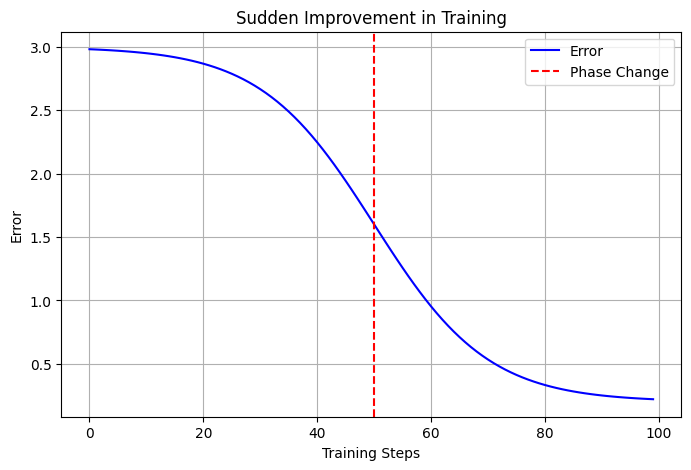

In [5]:
# Simulate training
steps = np.arange(0, 100)
error = 3 - 2.8 * (1 / (1 + np.exp(-(steps - 50) / 10)))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, error, 'b-', label='Error')
plt.axvline(50, color='red', linestyle='--', label='Phase Change')
plt.title('Sudden Improvement in Training')
plt.xlabel('Training Steps')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.savefig('phase_change.png')
plt.show()

**What’s This Graph?**
- Error stays high, then drops fast at the red line—when induction heads kick in.

**Deeper Insight:** This isn’t gradual learning; it’s a structural change in the model’s “brain.”

## 5. In-Context Learning: Instant Learning

### Subtopic 5.1: Definition
- In-context learning is when the model learns from examples in the input text, without retraining.

**Relatable Example:** Tell a kid, “Cows say moo, pigs say oink. What does a cow say?” They say “moo” from the example.

### Subtopic 5.2: Role of Induction Heads
- Induction heads spot the pattern in the examples and apply it.

**Simple Example:** “1=one, 2=two, 1=” → “one.”

Let’s try it.

In [6]:
# Use GPT-2
model = HookedTransformer.from_pretrained('gpt2', device=device)

# Prompt with examples
prompt = "Dog: woof\nCat: meow\nDog: "
tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
output = model.generate(tokens, max_new_tokens=5, do_sample=False)

print('Prompt:')
print(prompt)
print('Model says:')
print(tokenizer.decode(output[0]))

Loaded pretrained model gpt2 into HookedTransformer


  0%|          | 0/5 [00:00<?, ?it/s]

Prompt:
Dog: woof
Cat: meow
Dog: 
Model says:
Dog: woof
Cat: meow
Dog: ive been here for a


**What’s Happening?**
- The model sees “Dog: woof” and predicts “woof” again.

**Deeper Insight:** This flexibility makes transformers powerful for tasks like translation or Q&A.

## 6. Evidence and Analysis of Induction Heads

### Subtopic 6.1: Experimental Evidence
- **Ablation:** Disabling induction heads ruins in-context learning.
- **Timing:** They form during the phase change.

**Relatable Example:** Remove a car’s engine, and it won’t move. Induction heads are that engine for pattern learning.

### Subtopic 6.2: Visualization
- The diagonal attention pattern (seen earlier) confirms induction heads are active.

**Deeper Insight:** These experiments show induction heads aren’t random—they’re a key feature of transformers.

## 7. Advanced Topics

### Subtopic 7.1: Generalization
- Induction heads can handle “fuzzy” patterns, not just exact matches.

**Example:** “Apple = fruit, banana = fruit” → “orange = fruit.”

### Subtopic 7.2: Model Architecture
- Needs at least two layers for induction heads.
- Bigger models might have more or stronger heads.

**Analogy:** A two-story house can have a lookout tower; a one-story can’t.

## 8. Importance of Interpretability and Safety

- **Safety:** Prevents AI from copying bad patterns (e.g., bias).
- **Reliability:** Ensures consistent, correct outputs.
- **Future AI:** Guides us to build smarter, safer systems.

**Example:** Understanding a plane’s controls keeps it from crashing. Same with AI.

## 9. Conclusion

You’ve explored transformers from the ground up—how they focus with attention, spot patterns with induction heads, learn on the fly, and why that matters. With code and visuals, you’ve seen these ideas in action. Keep experimenting—try new prompts or check out [Transformer Circuits](https://transformer-circuits.pub)!